# Trabalho 1 - Parte 2 - Desenvolvimento da rede multicamadas


You will use the functions you'd implemented in the previous part to build a deep network, and apply it to your texture classification.   

Integrantes do grupo:
Ana Flávia Dias,
Luiza Ávila,
Pedro Achilles

## 1 - Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/trab1

import time
import numpy as np
import matplotlib.pyplot as plt

%run trab1a.py

%load_ext autoreload
%autoreload 2

np.random.seed(1)


Mounted at /content/drive
/content/drive/My Drive/trab1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2 - Dataset

You have to load the texture dataset and split into train and test.


In [ ]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data('testes')
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('dataset')
train_x_orig = np.array(train_x_orig)
train_y = np.array(train_y)
test_x_orig = np.array(test_x_orig)
test_y = np.array(test_y)
classes = np.array(classes)

The following code is a way to show you an image in the dataset and its class. 

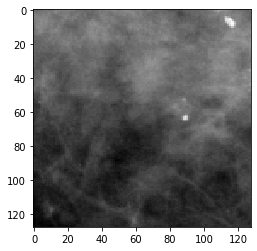

In [ ]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
#print("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [ ]:
# Explore your dataset 
m_train = np.array(train_x_orig).shape[0]
num_px = np.array(train_x_orig).shape[1]
m_test = np.array(test_x_orig).shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y.shape))

Number of training examples: 600
Number of testing examples: 600
Each image is of size: (128, 128, 3)
train_x_orig shape: (600, 128, 128)
train_y shape: (600, 4)
test_x_orig shape: (600, 128, 128)
test_y shape: (600, 4)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.


In [ ]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (16384, 600)
test_x's shape: (16384, 600)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build the deep neural network.

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation, for an animal dataset:

<img src="LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels


## 4 - L-layer Neural Network

Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
#def initialize_parameters_deep(layers_dims):
 #   ...
 #   return parameters 
#def L_model_forward(X, parameters):
 #   ...
  #  return AL, caches
#def compute_cost(AL, Y):
 #   ...
  #  return cost
#def L_model_backward(AL, Y, caches):
 #   ...
  #  return grads
#def update_parameters(parameters, grads, learning_rate):
 #   ...
  #  return parameters
```

In [ ]:
### CONSTANTS with the number of units per layer
#layers_dims = [16384, 2000, 700, 50, 4] #  5-layer model
layers_dims = [16384, 8000, 900, 100, 4] #  5-layer model

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


Run the cell below to train your model. The cost should decrease on every iteration. 

Cost after iteration 0: 2.772596
Cost after iteration 100: 2.615741
Cost after iteration 200: 2.507665
Cost after iteration 300: 2.432712
Cost after iteration 400: 2.380322


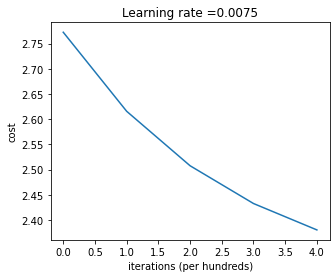

CPU times: user 4h 17min 30s, sys: 4min 40s, total: 4h 22min 10s
Wall time: 2h 15min


In [ ]:
%time parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 500, print_cost = True)

In [ ]:
train_x_orig = [item.flatten() for item in train_x_orig]
train_x_orig_trans = np.array(train_x_orig).T
guess, _ = L_model_forward(train_x_orig_trans, parameters)
print(guess.T)

[[0.34741843 0.34870515 0.3503803  0.34898286]
 [0.34801405 0.3489053  0.35041279 0.34922629]
 [0.34692922 0.34825951 0.35022741 0.34880346]
 ...
 [0.34860164 0.34913037 0.35062286 0.34949084]
 [0.34786154 0.34875111 0.35039501 0.34917047]
 [0.34744738 0.34806005 0.35075644 0.34886426]]


In [ ]:
test_x_orig = [item.flatten() for item in test_x_orig]
test_x_orig_trans = np.array(test_x_orig).T
guess, _ = L_model_forward(test_x_orig_trans, parameters)
print(guess.T)
#pred_train = predict(train_x, train_y, parameters)

[[0.34793636 0.34893901 0.35046093 0.34931263]
 [0.34756528 0.3486888  0.35040316 0.34911424]
 [0.34741457 0.34851806 0.35049849 0.34919924]
 ...
 [0.34695807 0.34849624 0.35043102 0.34896058]
 [0.34764952 0.34868541 0.35024288 0.3487231 ]
 [0.34670897 0.34810447 0.35036987 0.34884339]]


##  5) Results Analysis

Now, run your experiments and analyze the results!

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

test_y_actu = []
guess_pred = []

for classe in test_y:
  classe = tuple(classe)
  if (classe == (1, 0, 0, 0)):
    test_y_actu.append(1)
  elif (classe == (0, 1, 0, 0)):
    test_y_actu.append(2)
  elif (classe == (0, 0, 1, 0)):
    test_y_actu.append(3)
  elif (classe == (0, 0, 0, 1)):
    test_y_actu.append(4)

guess_transposto = guess.T
#print(guess_transposto)

for imagem in guess_transposto:
  estimativa = tuple(imagem)
  guess_pred.append(estimativa.index(max(estimativa)) + 1)

"""
for i in range(len(guess[0])):
  estimativa = tuple([guess[0][i], guess[1][i], guess[2][i], guess[3][i]])
  guess_pred.append(estimativa.index(max(estimativa)) + 1)
"""

#print('Correto:', test_y_actu)
#print('Predições:', guess_pred, '\n')

y_actu = pd.Series(test_y_actu, name='Atual')
y_pred = pd.Series(guess_pred, name='Predição')
df_confusion = pd.crosstab(y_actu, y_pred)
print('Matriz de confusão:', df_confusion, '', sep='\n')

acuracia = accuracy_score(test_y_actu, guess_pred)
print('Acurácia:', acuracia, '', sep='\n')

matriz = confusion_matrix(test_y_actu, guess_pred)
#print('Matriz de confusão:', matriz, sep='\n')
# 1-Σi=1..4 Σj≠i Mj,i / 12n.

n = 8
tmp = 0
for i, linha in enumerate(matriz):
  for j, coluna in enumerate(linha):
    if i != j:
      tmp += matriz[i][j]# / (12*n)
tmp /= 12*n
print('Especificidade:', 1-tmp, sep='\n')

Matriz de confusão:
Predição    3
Atual        
1         149
2         156
3         153
4         142

Acurácia:
0.255

Especificidade:
-3.65625


## 6) Testes


### Nossa base - 5 Camadas: [16384, 2000, 700, 50, 4]
```
Cost after iteration 2400: 2.243556

Learning rate: 0.0075

CPU times: user 5h 24min 49s, sys: 12min 37s, total: 5h 37min 27s
Wall time: 2h 52min 40s

Matriz de confusão:
Predição    4
Atual        
1         146
2         146
3         145
4         163

Acurácia:
0.27166666666666667

Especificidade:
-3.552083333333333
```

#### Nossas mudanças tentando melhorar a acurácia:

### Diminuir camadas - 4 Camadas: 
```
Cost after iteration 2400: 2.249586

Learning rate =0.0075

CPU times: user 35min 34s, sys: 2min 41s, total: 38min 15s
Wall time: 19min 38s

Matriz de confusão:
Predição    1
Atual        
1         147
2         159
3         149
4         145

Acurácia:
0.245

Especificidade:
-3.71875
```

### Alteração do número de neurônios - 5 camadas: [16384, 8000, 900, 100, 4]
```
Cost after iteration 2400: 2.380322

Learning rate: 0.0075

CPU times: user 8h 17min 30s, sys: 8min 40s, total: 8h 30min 10s
Wall time: 4h 15min

Matriz de confusão:
Predição    3
Atual        
1         149
2         156
3         153
4         142

Acurácia:
0.255

Especificidade:
-3.65625
```



### Mudança da taxa de aprendizado - 5 camadas: Learning rate = 2.5
```
Cost after iteration 2400: 2.249340

Learning rate = 2.5

CPU times: user 3h 4min 30s, sys: 5min 19s, total: 3h 9min 49s
Wall time: 1h 2min 18s

Matriz de confusão:
Predição    2
Atual        
1         155
2         149
3         146
4         150

Acurácia:
0.24833333333333332

Especificidade:
-3.697916666666667
```
### Aumentar camadas - 8 camadas : [16384, 8000, 3000, 1000, 700,200 ,50, 4]
``````
Cost after iteration 2000: 2.243095

Learning Rate = 0.0075

CPU times: user 13h 20min 34s, sys: 15min 20s, total: 13h 35min 54s
Wall time: 10h 20min 9s

Matriz de confusão:
Predição    1
Atual        
1         153
2         153
3         151
4         143

Acurácia:
0.255

Especificidade:
-3.65625
``````
### Notas das mudanças:
``````
Como pôde ser observado, nossas mudanças não afetaram de forma significativa o código. A rede ainda não conseguiu aprender. 

Mudança das camadas - aumentar ou diminuir as camadas altera o modo como a rede aprende. Deve passar por mais/menos neurônios.

Alteração dos neurônios- aumentar ou diminuir a quantidade de neurônios em cada camada. Isso pode alterar quais neurônios 'acendem', ou seja, possuo maior chance de acertar.

Mudança na taxa de aprendizado - a que ritmo os pesos são atualizados.
``````
